In [4]:
from sklearn.ensemble import IsolationForest
import pandas as pd
import numpy as np
# Define the mo

In [15]:
df = pd.read_csv("dataset.csv", index_col = 0, delimiter = ',')

In [30]:

model = IsolationForest(contamination=0.05)

# Fit the model to the data
model.fit(df)

# Use the model to predict anomalies in the data
df['anomaly'] = model.predict(df)

# Print the number of anomalies detected
print("Number of anomalies detected: ", sum(df['anomaly'] == -1))


/Users/macbook/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Number of anomalies detected:  516


In [17]:
df['anomaly']

time
0.00        -1
60.48       -1
120.96      -1
181.44      -1
241.92      -1
            ..
604679.00    1
604740.00    1
604800.00    1
604800.00   -1
604800.00   -1
Name: anomaly, Length: 10330, dtype: int64

In [24]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Preparing the data
# Assuming anomalies are a very small portion of the dataset
normal_data = df[df['anomaly'] == 1]  # assuming 'anomaly' column labels anomalies
anomaly_data = df[df['anomaly'] == -1]

# Normalize the data
sc = StandardScaler()
normal_data = sc.fit_transform(normal_data)

# Create train and validation sets
X_train, X_val = train_test_split(normal_data, test_size=0.2, random_state=42)

# Define the autoencoder model
input_dim = X_train.shape[1]  # Number of features
encoding_dim = 10  # This is arbitrary, you can adjust this number

input_layer = tf.keras.layers.Input(shape=(input_dim, ))
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh")(input_layer)
encoder = tf.keras.layers.Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='tanh')(encoder)
decoder = tf.keras.layers.Dense(input_dim, activation='relu')(decoder)

autoencoder = tf.keras.models.Model(inputs=input_layer, outputs=decoder)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(X_val, X_val),
                verbose=1)

# Use the autoencoder to predict the anomalies
X_test = sc.transform(df)
predicted = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predicted, 2), axis=1)
df['mse'] = mse

# Set a threshold (you can adjust this based on your understanding of the data)
threshold = np.percentile(df['mse'], 95)

# Anything above the threshold is considered an anomaly
df['anomaly'] = df['mse'] > threshold


Epoch 1/50
13/13 [==============================] - 2s 21ms/step - loss: 0.9015 - val_loss: 0.9817
Epoch 2/50
13/13 [==============================] - 0s 7ms/step - loss: 0.8354 - val_loss: 0.9308
Epoch 3/50
13/13 [==============================] - 0s 7ms/step - loss: 0.7849 - val_loss: 0.8896
Epoch 4/50
13/13 [==============================] - 0s 8ms/step - loss: 0.7406 - val_loss: 0.8551
Epoch 5/50
13/13 [==============================] - 0s 7ms/step - loss: 0.7056 - val_loss: 0.8261
Epoch 6/50
13/13 [==============================] - 0s 7ms/step - loss: 0.6765 - val_loss: 0.8010
Epoch 7/50
13/13 [==============================] - 0s 7ms/step - loss: 0.6524 - val_loss: 0.7820
Epoch 8/50
13/13 [==============================] - 0s 7ms/step - loss: 0.6358 - val_loss: 0.7688
Epoch 9/50
13/13 [==============================] - 0s 8ms/step - loss: 0.6252 - val_loss: 0.7598
Epoch 10/50
13/13 [==============================] - 0s 7ms/step - loss: 0.6178 - val_loss: 0.7539
Epoch 11/50
13/13 

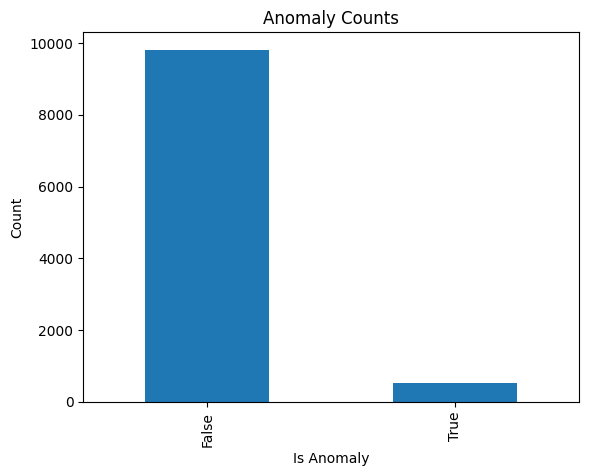

In [28]:
import matplotlib.pyplot as plt

# Plot a histogram
df['anomaly'].value_counts().plot(kind='bar')

plt.title('Anomaly Counts')
plt.xlabel('Is Anomaly')
plt.ylabel('Count')

plt.show()


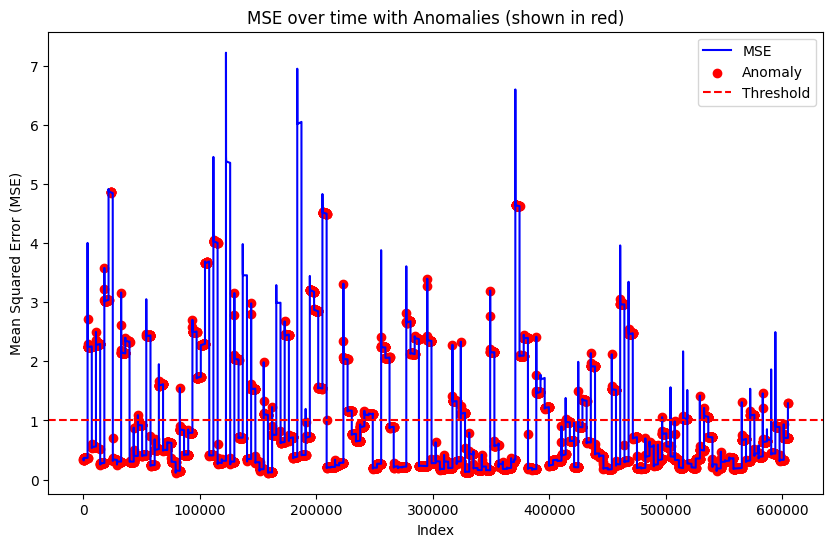

In [31]:
import matplotlib.pyplot as plt

# Creating a new dataframe to hold the anomaly information
anomaly_df = df[df['anomaly'] == True]

# Plotting the anomalies in red
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['mse'], 'b', label='MSE')
plt.scatter(anomaly_df.index, anomaly_df['mse'], color='red', label='Anomaly')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('MSE over time with Anomalies (shown in red)')
plt.xlabel('Index')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()


Outlier indices:  (array([    0,     1,     2, ..., 10325, 10326, 10327]),)
Outliers:  [   0.            0.            0.         ... 2168.48122159 2168.48122159
 2168.48122159]


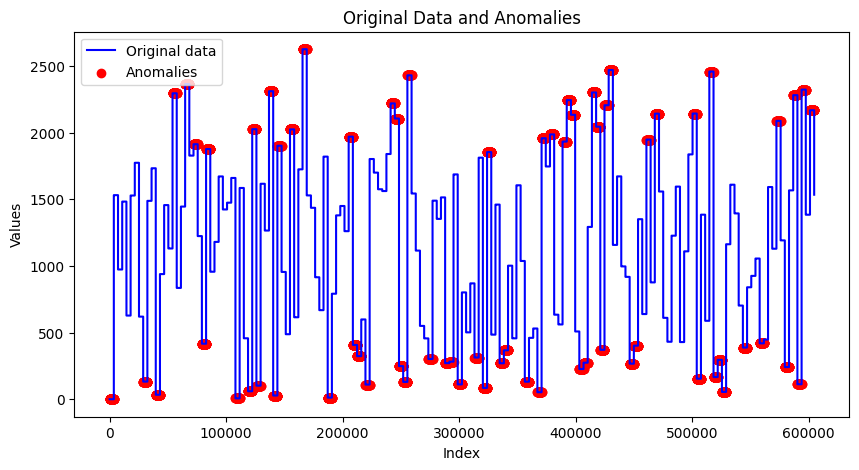

In [32]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

# Select your feature, replace 'YourFeature' with your column name
df_feature = df['P_all_power']

# calculate absolute z-score
z = np.abs(stats.zscore(df_feature))

# define threshold
threshold = 1

# get the indices of the outliers
outlier_indices = np.where(z > threshold)

# Print the outlier indices
print("Outlier indices: ", outlier_indices)

# Select the outliers from the original DataFrame
outliers = df_feature.iloc[outlier_indices]

# Print the outliers
print("Outliers: ", outliers.values)

# Create plot
plt.figure(figsize=(10,5))
plt.plot(df_feature.index, df_feature.values, color='blue', label='Original data')
plt.scatter(outliers.index, outliers.values, color='red', label='Anomalies')

plt.title('Original Data and Anomalies')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend(loc='best')
plt.show()
